In [1]:
import warnings
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
from yellowbrick.text.freqdist import FreqDistVisualizer

########## NLP
# pre-processing 
import re 
import string 
import nltk
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
import spacy 
# topic-models 
from sklearn.decomposition import NMF, LatentDirichletAllocation

warnings.filterwarnings('ignore') # turn off warnings 
%matplotlib inline
nlp = spacy.load('en') # load spacy model
en_stopwords = set(stopwords.words('english')) # SKLEARN'S ENGLISH_STOP_WORDS TOO GREEDY
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [1]:
import spacy
import nltk
import re
import string
import sys
import pandas as pd
import numpy as np
#from stop_word_list import *
#from openfile_kn import *
import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: No module named pyLDAvis.gensim

## Remove irrelevant products

In [2]:
data = pd.read_pickle('../data/reviews_data_clean_v3') # better to use pickle
data.head()

,asin,helpful,reviewText,overall,summary,description,title,categories_clean,review_length
0,0929619730,"[0, 0]",B-flax-D is a regular at our house. It does it...,5.0,Dpes the job well,Contains Organic Cold-Milled Flaxseed\nValuabl...,New Generation B-Flax-D,"Health & Personal Care, Vitamins & Dietary Sup...",224
2,0978559088,"[1, 1]",I started taking this after both my parents di...,5.0,Bioavailability is the key,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",1065
4,0978559088,"[0, 0]",I really liked this product because it stayed ...,5.0,"I can't find this product any longer, and I wi...",Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",767
5,0978559088,"[3, 3]","Resveratrol is a polar compound, very insolubl...",5.0,Just the Resveratrol product we need,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup...",1422
6,1427600228,"[3, 3]",I bought several of these bracelets for my YMC...,5.0,The kids love these bracelets,The Zenlet Green Tea Bracelet provides you wit...,Zenlet Green Tea Love Bracelet - All Natural,"Health & Personal Care, Vitamins & Dietary Sup...",186


In [7]:
#data2 = pd.read_pickle('/Users/booranium/practicum/amazon/data/data_tokenized') # better to use pickle
#len(data2), data.asin.nunique()

IOError: [Errno 2] No such file or directory: '/Users/booranium/practicum/amazon/data/data_tokenized'

In [3]:
def try_split_3(string):
    ls = string.split(',')
    try:
        return ls[2].strip()
    except:
        pass
    
def try_split_4(string):
    ls = string.split(',')
    try:
        return ls[3].strip()
    except:
        pass    

def try_split_5(string):
    ls = string.split(',')
    try:
        return ls[4].strip()
    except:
        pass

def try_split_6(string):
    ls = string.split(',')
    try:
        return ls[5].strip()
    except:
        pass  

def try_split_7(string):
    ls = string.split(',')
    try:
        return ls[6].strip()
    except:
        pass

In [4]:
data['cat1'] = data.categories_clean.apply(lambda x: x.split(',')[0])
data['cat2'] = data.categories_clean.apply(lambda x: x.split(',')[1].strip())
data['cat3'] = data.categories_clean.apply(try_split_3)
data['cat4'] = data.categories_clean.apply(try_split_4)
data['cat5'] = data.categories_clean.apply(try_split_5)
data['cat6'] = data.categories_clean.apply(try_split_6)
data['cat7'] = data.categories_clean.apply(try_split_7)

In [8]:
data_clean1 = data[data.cat1 == 'Health & Personal Care'] 
#exclude: Cell Phones & Accessories

data_clean2 = data_clean1[data_clean1.cat2 == 'Vitamins & Dietary Supplements'] 
# exclude: Sports Nutrition, Baby & Child Care

data_clean3 = data_clean2[data_clean2.cat3.isin(['Supplements','Vitamins','Minerals', 'Herbal Supplements'])]
# excludes: Multi & Prenatal Vitamins, Weight Loss, Clothing

In [11]:
data.groupby('cat1').asin.count()

cat1
Cell Phones & Accessories        50
Health & Personal Care       355199
Name: asin, dtype: int64

In [14]:
data_clean1.groupby('cat2').asin.count()

cat2
Baby & Child Care                    385
Sports Nutrition                    5322
Vitamins & Dietary Supplements    349492
Name: asin, dtype: int64

In [17]:
data_clean2.groupby('cat3').asin.count()

cat3
Clothing                         1
Herbal Supplements           63259
Minerals                     22340
Multi & Prenatal Vitamins    44775
Supplements                  91493
Vitamins                     40474
Weight Loss                  74541
Name: asin, dtype: int64

In [9]:
len(data_clean3), data_clean3.asin.nunique()

(217566, 26820)

In [22]:
data_clean3.to_pickle('../data/data_clean_v4')

In [22]:
# table created based on 'data tokenized'
#small = data_clean3[['asin', 'helpful', 'reviewText', 'overall', 'summary', 'description', 'title', 'categories_clean', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7']]

In [25]:
#small.reset_index().to_feather('data_clean_v3')

In [19]:
#small = pd.read_feather('../data/data_clean_v3')
#len(small)

217530

## Split into individual categories

In [4]:
small.groupby('cat3').asin.count()

cat3
Herbal Supplements    63246
Minerals              22339
Supplements           91477
Vitamins              40468
Name: asin, dtype: int64

In [4]:
herbs_only = small[small.cat3 == 'Herbal Supplements']
min_only = small[small.cat3 == 'Minerals']
supp_only = small[small.cat3 == 'Supplements']
vit_only = small[small.cat3 == 'Vitamins']

In [5]:
# for prototyping
fish_oil_only = supp_only[supp_only.cat4 == 'Fish Oil']

## Preprocessing

from: https://github.com/nicharuc/Collocations/blob/master/cleanreviews.py

In [17]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128) #remove non-ascii characters
reviews = small.reviewText.map(lambda x: _removeNonAscii(x))

In [28]:
#function to clean and lemmatize comments
def cleaner(text):
    #remove punctuations
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    #nopunct = regex.sub(" ", str(text)) # string formatting issue 
    nopunct = regex.sub(" ", text)
    #use spacy to lemmatize comments
    doc = nlp(nopunct, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [29]:
#apply function to clean and lemmatize comments
lemmatized = reviews.map(cleaner)

In [30]:
lemmatized.head(3)

0    [-PRON-, start, take, this, after, both, -PRON...
1    [-PRON-, really, like, this, product, because,...
2    [resveratrol, be, a, polar, compound,  , very,...
Name: reviewText, dtype: object

In [31]:
#make sure to lowercase everything
lemmatized_lwr = lemmatized.map(lambda x: [word.lower() for word in x])

#turn all comments' tokens into one single list
unlist_reviews = [item for items in lemmatized_lwr for item in items]

In [35]:
len(lemmatized_lwr)

217530

In [34]:
len(unlist_reviews)

14982298

In [127]:
lemmatized_lwr.head()

0    [-pron-, start, take, this, after, both, -pron...
1    [-pron-, really, like, this, product, because,...
2    [resveratrol, be, a, polar, compound,  , very,...
3    [-pron-, buy, several, of, these, bracelet, fo...
4    [-pron-, buy, a, few, the, other, week, just, ...
Name: reviewText, dtype: object

## Bigrams and Trigrams

from: https://medium.com/@nicharuch/collocations-identifying-phrases-that-act-like-individual-words-in-nlp-f58a93a2f84a

In [36]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_reviews)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_reviews)

### Method 1: Frequency with part of speech filters

In [1]:
#bigrams
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)

#trigrams
trigram_freq = trigramFinder.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

NameError: name 'bigramFinder' is not defined

In [38]:
#get english stopwords
en_stopwords = set(stopwords.words('english'))
#function to filter for ADJ/NN bigrams
def rightTypes(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
#filter bigrams
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x))]

#function to filter for trigrams
def rightTypesTri(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords or word.isspace():
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False
#filter trigrams
filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x))]

In [46]:
len(filtered_bi), len(filtered_tri)

(313821, 239737)

In [79]:
filtered_bi_freq = filtered_bi[filtered_bi.freq > 20].bigram.tolist()
filtered_tri_freq = filtered_tri[filtered_tri.freq > 20].trigram.tolist()

### Method 2: Pointwise Mutual Information

In [41]:
#filter for only those with more than 20 occurences
bigramFinder.apply_freq_filter(20)
trigramFinder.apply_freq_filter(20)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

In [44]:
len(bigramPMITable), len(trigramPMITable)

(58344, 78163)

In [81]:
pmi_bigram_freq = bigramPMITable[bigramPMITable.PMI>8].bigram.tolist()
pmi_trigram_freq = trigramPMITable[trigramPMITable.PMI>18].trigram.tolist()

In [85]:
bigrams_full = filtered_bi_freq+pmi_bigram_freq
bigram_list = list(set(bigrams_full))

trigrams_full = filtered_tri_freq+pmi_trigram_freq
trigram_list = list(set(trigrams_full))

### Replace grams in text

In [86]:
# replace the word with selected ngram
def trigram_concat(text):
    text1 = text.lower()
    for ngram in trigram_list:
        raw = str(' '.join(ngram))
        clean = str('_'.join(ngram))
        text1 = text1.replace(raw, clean)
    return text1

In [87]:
# replace the word with selected ngram
def bigram_concat(text):
    text1 = text.lower()
    for ngram in bigram_list:
        raw = str(' '.join(ngram))
        clean = str('_'.join(ngram))
        text1 = text1.replace(raw, clean)
    return text1

In [88]:
trigrammed = reviews.map(trigram_concat)

In [89]:
bigrammed = trigrammed.map(bigram_concat)

In [128]:
reviews[:10]

0    I started taking this after both my parents di...
1    I really liked this product because it stayed ...
2    Resveratrol is a polar compound, very insolubl...
3    I bought several of these bracelets for my YMC...
4    I bought a few the other week just to see what...
5    This bracelet is so simple yet so elegant.  I ...
6    I recently bought a bunch of these to hand out...
7    These are very gentle on your body never know ...
8    I was extremely impressed with the super fast ...
9    I've been using this product for about 3 month...
Name: reviewText, dtype: object

In [90]:
bigrammed[:10]

0    i started taking this after both my parents di...
1    i really liked this product because it stayed ...
2    resveratrol is a polar compound, very insolubl...
3    i bought several of these bracelets for my ymc...
4    i bought a few the other week just to see what...
5    this bracelet is so simple yet so elegant.  i ...
6    i recently bought a bunch of these to hand out...
7    these are very gentle on your body never know ...
8    i was extremely impressed with the super_fast_...
9    i've been using this product for about 3 month...
Name: reviewText, dtype: object

In [91]:
pd.DataFrame(bigrammed).to_pickle('grams')

In [ ]:
# remove punctuation

## Plot token frequency

In [4]:
#data = pd.read_pickle('reviews_gram_concat')

In [102]:
def spacy_stem(toke):
    doc = nlp(toke, disable=['parser','ner'])
    lemma = [token.lemma_ for token in doc]
    return lemma

In [124]:
tokenized = bigrammed.apply(spacy_stem)

In [125]:
tokenized.head()

0    [i, start, take, this, after, both, -PRON-, pa...
1    [i, really, like, this, product, because, -PRO...
2    [resveratrol, be, a, polar, compound, ,, very,...
3    [i, buy, several, of, these, bracelet, for, -P...
4    [i, buy, a, few, the, other, week, just, to, s...
Name: reviewText, dtype: object

In [94]:
#custom_punct = string.punctuation.replace('_','')
#
#def tokenize(text):   
#    text = text.lower()
#    text = re.sub('[' + custom_punct + '0-9\\r\\t\\n]', ' ', text)
#    tokens = nltk.word_tokenize(text)
#    tokens = [w for w in tokens if len(w) > 2]
#    tokens = [w for w in tokens if not w in en_stopwords]
#    tokens = [stemmer.stem(w) for w in tokens] 
#    return tokens 
#
#vectorizer = CountVectorizer(tokenizer = tokenize) # remove stop words
#docs = vectorizer.fit_transform(bigrammed)
#features = vectorizer.get_feature_names()

In [96]:
len(features)

93226

In [129]:
custom_punct = string.punctuation.replace('_','')

def tokenize_spaced(text):   
    text = re.sub('[' + custom_punct + '0-9\\r\\t\\n]', ' ', text)
    text = spacy_stem(text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w for w in tokens if not w in en_stopwords]
    return tokens 

vectorizer_spaced = CountVectorizer(tokenizer = tokenize)
docs_spaced = vectorizer_spaced.fit_transform(bigrammed)
features_spaced = vectorizer_spaced.get_feature_names()

In [130]:
len(features_spaced)

93226

Need to manually clean words that start with _ since _ is being ignored 

In [159]:
features_spaced[:10]

['\\bought',
 '\\day',
 '\\heart_palpit',
 '\\jarrow_formulas_curcumin_',
 '\\love',
 '\\muscl',
 '____',
 '__________________________________________________________________________________couldn',
 '__________________________________________________________________________________note',
 '________________________________________________six']

In [172]:
def clean_features(string):
    string_clean = re.sub(r'^(\\)', '', string)
    string_clean = re.sub(r'(\+)$', '', string_clean)
    string_clean = re.sub(r'^(_+)', '', string_clean)
    string_clean = re.sub(r'(_+)$', '', string_clean)
    return string_clean

In [173]:
features_spaced_clean = list(map(clean_features, features_spaced))

In [174]:
features_spaced_clean[:10]

['bought',
 'day',
 'heart_palpit',
 'jarrow_formulas_curcumin',
 'love',
 'muscl',
 '',
 'couldn',
 'note',
 'six']

In [176]:
features_spaced_clean2 = [i for i in features_spaced_clean if i != '']

In [190]:
[i for i in features_spaced_clean2 if i.startswith('zzz')]

['zzz',
 'zzzz',
 'zzzzs',
 'zzzzz',
 'zzzzzuil',
 'zzzzzz',
 'zzzzzzzzs',
 'zzzzzzzzzzzzz']

In [183]:
len(features_spaced_clean), len(features_spaced_clean2), len(features)

(93226, 93225, 93226)

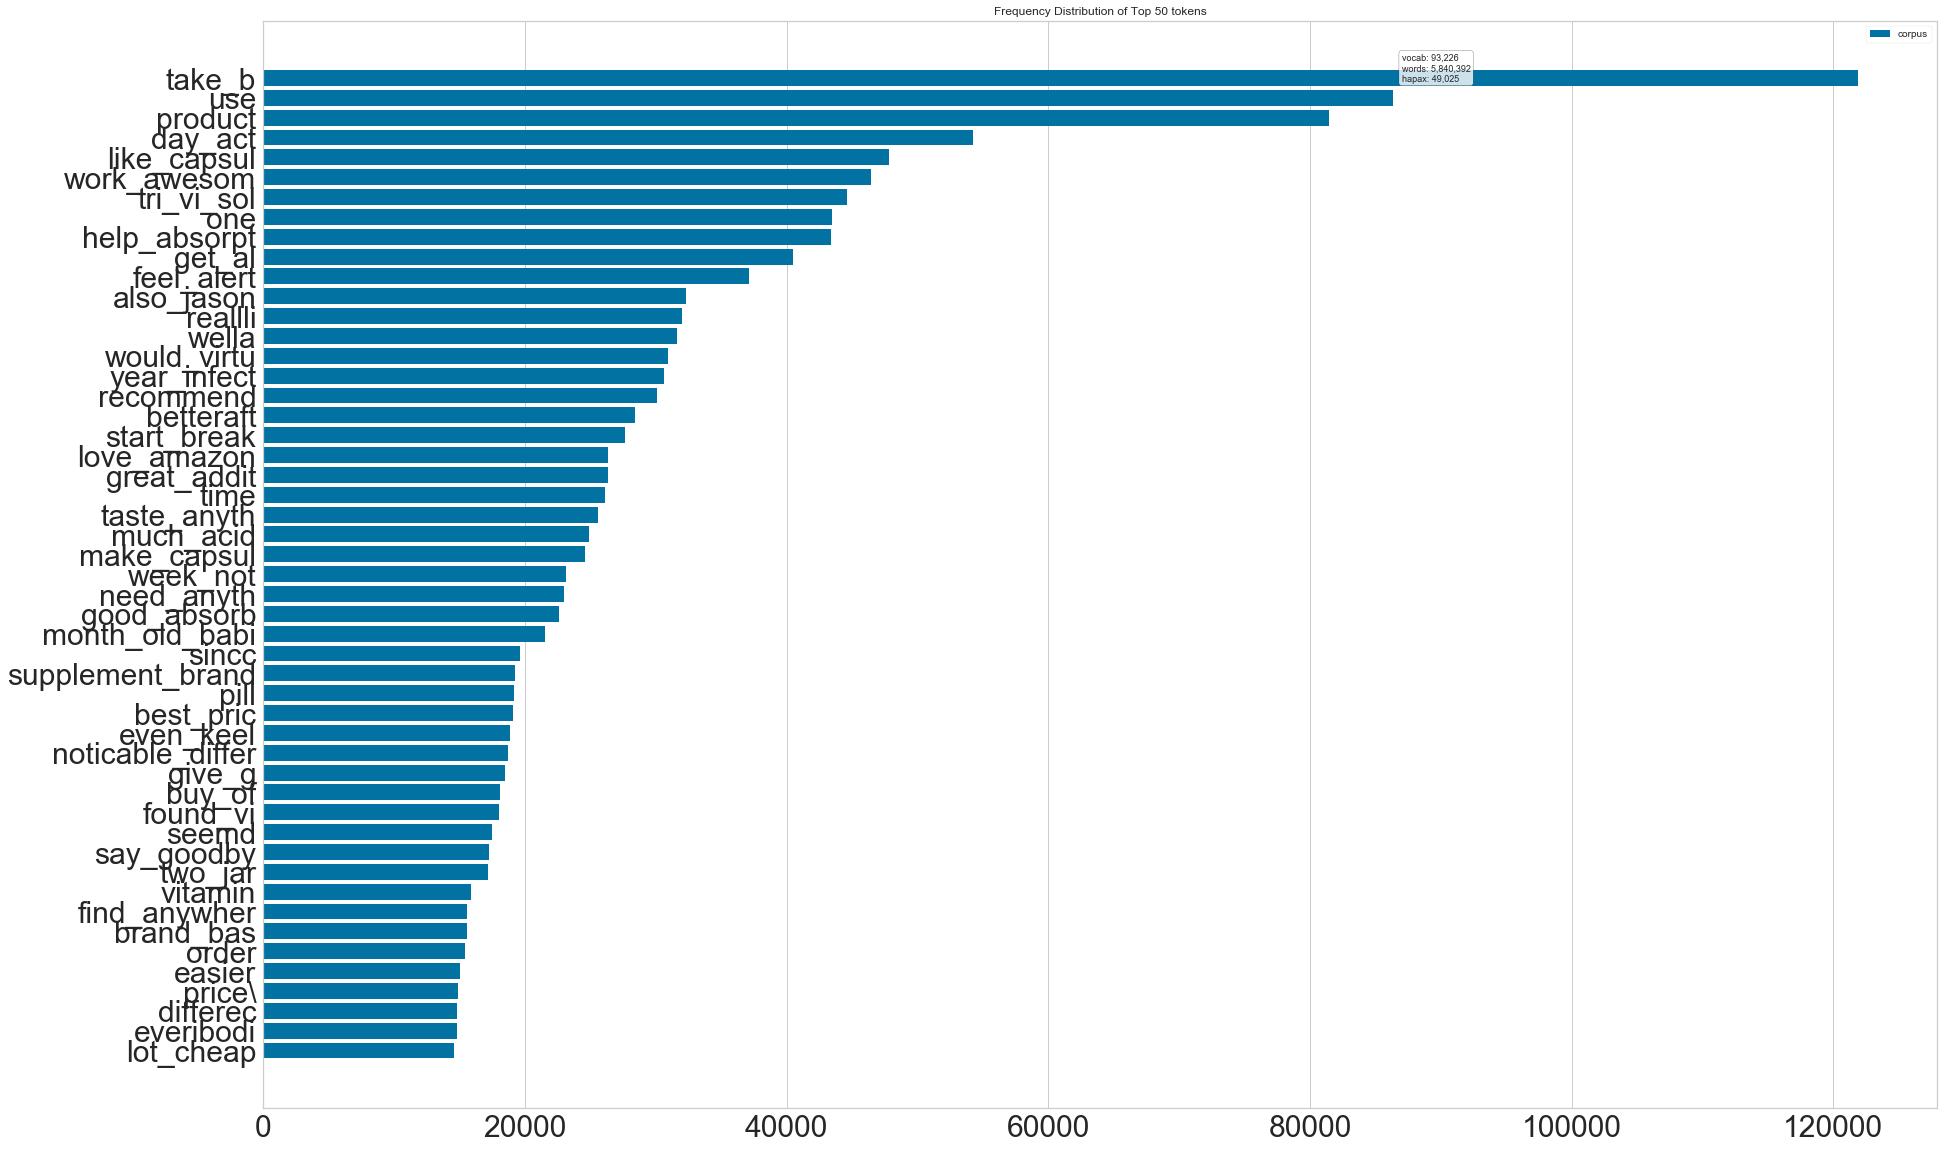

In [184]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))  # the size you want
plt.tick_params(labelsize=30)

visualizer_spaced = FreqDistVisualizer(features=features_spaced_clean2)
visualizer_spaced.fit(docs_spaced)
visualizer_spaced.poof()

In [185]:
visualizer_spaced

FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1b637494a8>,
          color=None,
          features=['bought', 'day', 'heart_palpit', 'jarrow_formulas_curcumin', 'love', 'muscl', 'couldn', 'note', 'six', 'i', 'updat', 'updat', 'mi', 'updat', 'followup', 'mi', 'never', 'you', 'automatically', 'before', 'billion', 'billion_cfu', 'billion_cfus', 'billion_or', 'billion_organ', 'bottl', 'capsu... 'zyzz', 'zza', 'zzz', 'zzzz', 'zzzzs', 'zzzzz', 'zzzzzuil', 'zzzzzz', 'zzzzzzzzs', 'zzzzzzzzzzzzz'],
          n=None, orient='h')

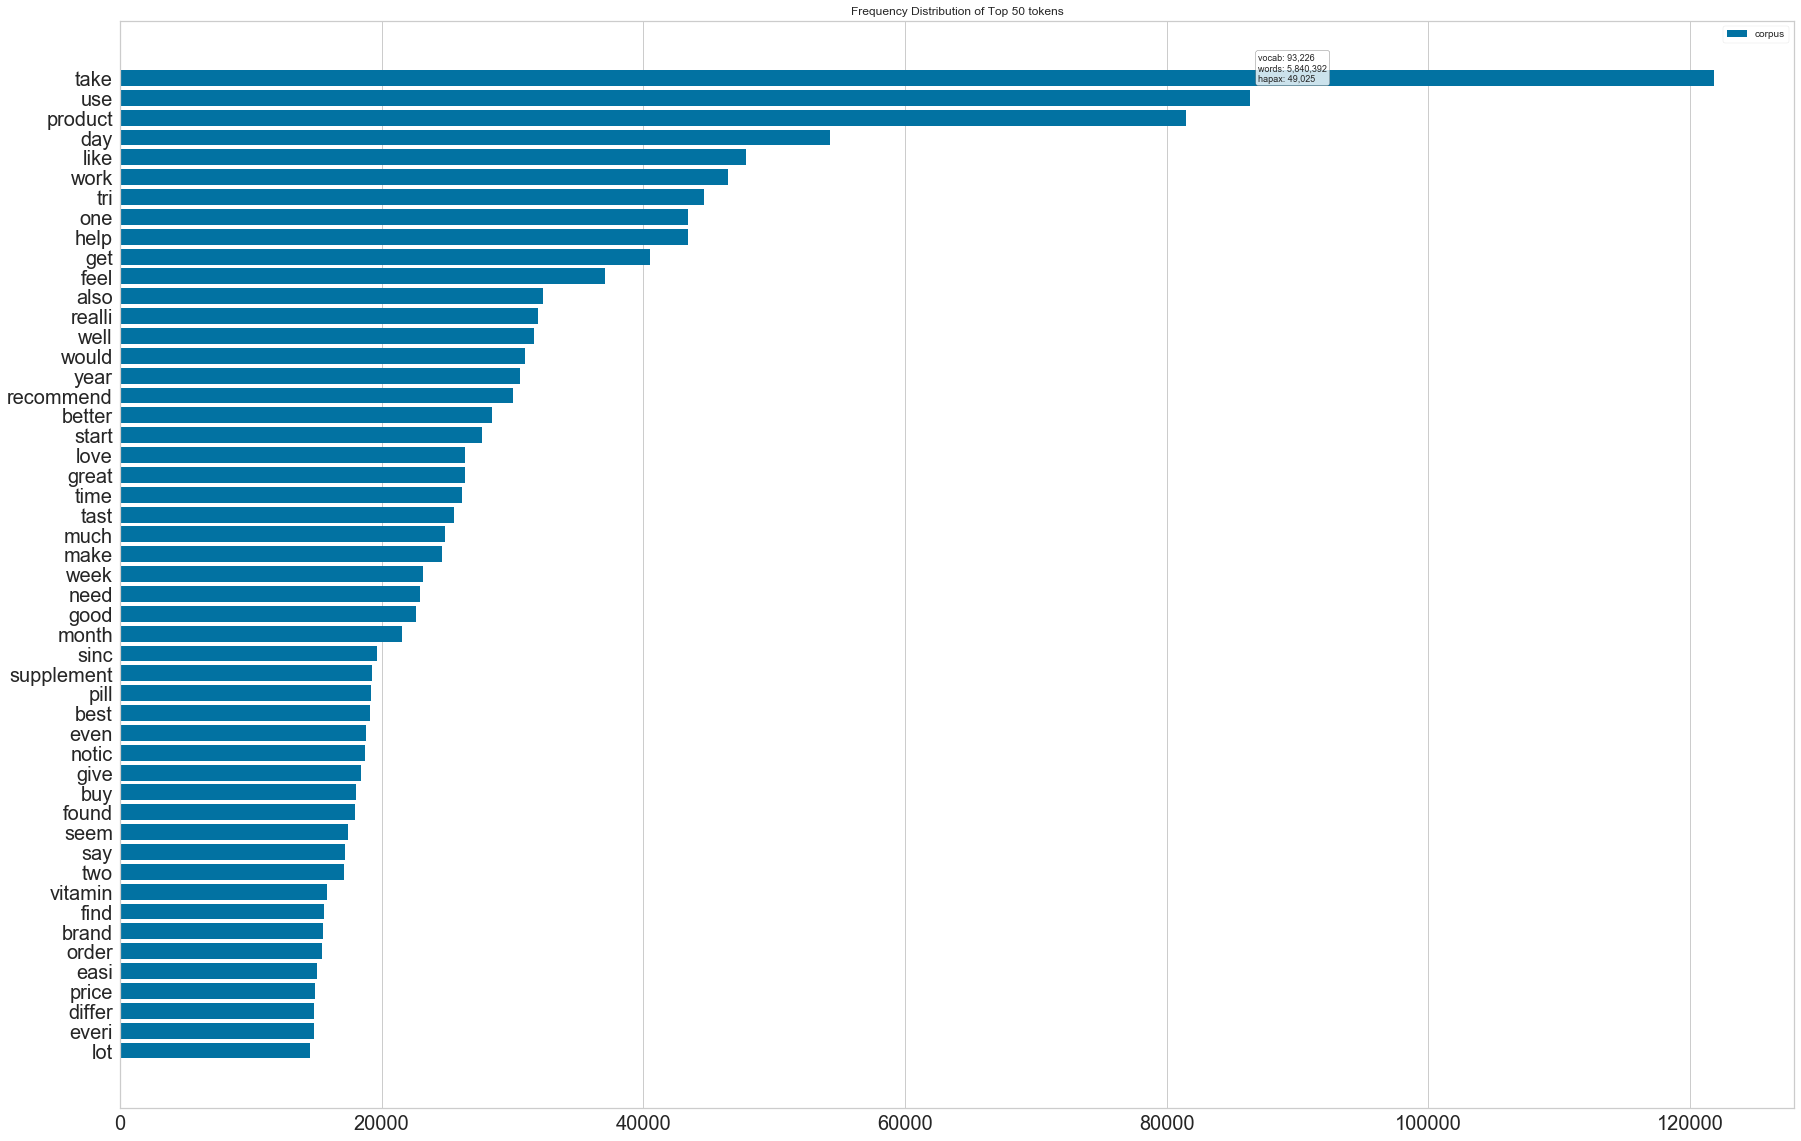

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))  # the size you want
plt.tick_params(labelsize=20)

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## NMF

In [180]:
feature_names = vectorizer_spaced.get_feature_names()

In [181]:
for n in [4,5,6,7]:
    nmf = NMF(n_components=n, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(docs)
    # if n_components=no_topics --> all features are kept
    print('Num. Topics: ', n)
    num_top_words = 20
    for topic_idx, topic in enumerate(nmf.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print('')

Num. Topics:  4
Topic 0:
like tri day work one get feel realli help would well better also tast time much make give week even
Topic 1:
use year also skin hair make sinc start time well great month love help continu brand drop week easi much
Topic 2:
product recommend would love help purchas highly_recommend order the_product amazon price buy found well tri great year realli also result
Topic 3:
take day start pill year supplement month sinc week vitamin feel notic also help one two time get doctor everi

Num. Topics:  5
Topic 0:
like tri work one get feel realli help tast well also better would make much give good even great say
Topic 1:
use year also skin hair start sinc time month make well great continu love week drop help face brand much
Topic 2:
product recommend would love purchas help highly_recommend order the_product amazon price buy year found result happi compani great well continu
Topic 3:
take start pill supplement year help also vitamin sinc feel month notic one get docto

## LDA

In [182]:
for n in [4,5,6,7]:
    lda = LatentDirichletAllocation(n_topics=n, max_iter=5, learning_method='online',\
                                    learning_offset=50.,random_state=0).fit(docs)
    print('Num. Topics: ', n)
    num_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print('')

Num. Topics:  4
Topic 0:
product use buy price purchas order would the_product one amazon
Topic 1:
use tast like skin love make drink hair mix great
Topic 2:
take day product feel work help use tri start week
Topic 3:
take supplement vitamin also fish_oil one help bodi need brand

Num. Topics:  5
Topic 0:
take day feel tri use work product get like start
Topic 1:
use skin hair receiv bottl nail nice smell also look
Topic 2:
take help product use supplement recommend pain also notic sleep
Topic 3:
tast like take mix fish_oil supplement also vitamin make one
Topic 4:
product use buy easi love price would recommend like one

Num. Topics:  6
Topic 0:
take day product help use feel work tri start week
Topic 1:
use skin hair tast mix drink like water make love
Topic 2:
compani the_product ship excel packag arriv receiv good_product time provid
Topic 3:
take fish_oil vitamin probiot supplement bodi eat also food need
Topic 4:
product use like buy love take one tri easi tast
Topic 5:
benefit i

## Nouns Only

In [108]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN', 'NNP', 'VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    return filtered

In [109]:
nn_reviews = bigrammed.map(noun_only)

In [110]:
nn_reviews.head()

0    [i, s, t, r, t, e, d, k, i, g, t, h, t, e, r, ...
1    [i, r, e, l, l, y, l, i, e, d, t, h, p, r, o, ...
2    [r, e, s, v, e, t, r, o, l,  , i, p, o, r, m, ...
3    [i, b, o, g, h, t, s, e, v, e, l, t, h, e, s, ...
4    [i, b, o, g, h, t, f, e, w, t, h, e, h, e, r, ...
Name: reviewText, dtype: object

In [113]:
test = bigrammed[:1]

In [117]:
pos_comment = nltk.pos_tag(test.values)
pos_comment

[("i started taking this after both my parents died of cancer as it supposed to enhance your immune_system - the story_on 60 minutes on resveratrol was incredibly inspiring. doing some research on the internet, it is indicated that taking resveratrol in lozenge form is preferable as it is broken down by stomach_acids.  the ez-melt formula recommended in another review is ok, but it is dissolved in the mouth much more quickly than this lozenge formula, while dissolving more slowly is preferable according to my research.this product has the_greatest side_effect - since taking it, i haven't had colds or sore_throats.  soon after starting to take it every day, i was starting to come down with a cold, with all my usual symptoms, and was anticipating being very sick the next_day, as is my usual pattern.  but i never did get as sick as anticipated - taking this product is the only reason i can come up with.  since then, i've had no colds or sore_throats - it has been great.  i recommend this 

In [118]:
filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
filtered

["i started taking this after both my parents died of cancer as it supposed to enhance your immune_system - the story_on 60 minutes on resveratrol was incredibly inspiring. doing some research on the internet, it is indicated that taking resveratrol in lozenge form is preferable as it is broken down by stomach_acids.  the ez-melt formula recommended in another review is ok, but it is dissolved in the mouth much more quickly than this lozenge formula, while dissolving more slowly is preferable according to my research.this product has the_greatest side_effect - since taking it, i haven't had colds or sore_throats.  soon after starting to take it every day, i was starting to come down with a cold, with all my usual symptoms, and was anticipating being very sick the next_day, as is my usual pattern.  but i never did get as sick as anticipated - taking this product is the only reason i can come up with.  since then, i've had no colds or sore_throats - it has been great.  i recommend this p